In [28]:
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from scipy import stats, fft

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [29]:
## checking tensorflow version
print("Tensorflow version is {}.".format(tf.__version__))

Tensorflow version is 2.2.0.


In [30]:
## data loading
# All files should be in the same directory (folder)

normal_data_file = "20220323_225959_Normal_lab9_data.csv" # normal condition filename: You must change this!
abnormal_data_file = "20220323_230948_Abnormal_lab9_data.csv" # abnormal condition filename: You must chage this!

df_normal = pd.read_csv(normal_data_file) # normal dataframe
df_abnormal = pd.read_csv(abnormal_data_file) # abnormal dataframe

frames = [df_normal, df_abnormal] # frame list to merge two dataframes into one

df = pd.concat(frames) # new concatenated dataframe

df # display dataframe

,Condition,Xacc array [m/s2],Yacc array [m/s2],Zacc array [m/s2]
0,Normal,0.0 0.0 0.8629851999999999 0.0 -0.9414384 -1.0...,1.1767979999999998 -0.784532 1.176797999999999...,8.7867584 11.2972608 10.0420096 10.0420096 9.3...
1,Normal,-1.6475172 3.7657536 -1.3337044 -2.35359599999...,-0.4707192 0.0 0.0 -1.3337044 -1.569064 0.0 0....,9.1005712 9.8851032 10.5127288 10.0420096 9.57...
2,Normal,0.6276256 0.0 0.2353596 -1.0983448 -0.5491724 ...,0.9414384 2.4320492 1.1767979999999998 -0.0784...,8.8652116 10.6696352 8.1591328 8.1591328 10.59...
3,Normal,0.8629851999999999 0.0 0.784532 -1.3337044 -0....,-0.6276256 1.4121576 1.7259703999999998 0.7845...,10.591182 8.5513988 9.1790244 8.7083052 9.2574...
4,Normal,0.5491724 1.2552512 0.0 0.0 0.5491724 0.0 0.0 ...,1.569064 -2.5889556 0.4707192 0.0 3.7657536 1....,8.394492399999999 12.8663248 8.5513988 9.41438...
...,...,...,...,...
295,Abnormal,1.2552512 2.5105024 8.1591328 4.314926 -0.9414...,-5.0210048 -5.099458 -3.8442068 -0.6276256 0.6...,9.8851032 8.9436648 11.2972608 6.3547091999999...
296,Abnormal,4.314926 0.0 3.2165812 4.9425516 -3.2165812 -1...,-5.962443199999999 -5.0210048 -7.2176943999999...,12.709418399999999 7.060788 12.003339599999999...
297,Abnormal,4.0011132 5.0210048 2.1966896 0.0 0.784532 7.5...,-3.8442068 -7.3746008 -6.903881599999999 -4.47...,8.7867584 12.552512 12.4740588 8.629852 9.3359...
298,Abnormal,0.6276256 -4.5502856 -4.158019599999999 -0.941...,-1.8044235999999998 1.569064 4.9425516 1.56906...,11.924886399999998 7.9237732 10.1204628 7.6884...


In [31]:
## Data Transformation
# X-axis: 'Xacc array [m/s2]'
# Y-axis: 'Yacc array [m/s2]'
# Z-axis: 'Zacc array [m/s2]'
DIMENSION = 'Xacc array [m/s2]' # in this case, X-axis acceleration data

# Exploding the values contained in selected column and converting the string values into float values
df = pd.concat([df['Condition'],df[DIMENSION].str.split(' ', expand=True).astype(float)], axis=1) # transform space delimited array to each value
ds = df.copy() # make ds by copying df

In [32]:
#Converting the Classifier into binary values
ds.loc[df['Condition'] == 'Normal', 'Status'] = 1 # if Condition column is 'Normal', Give 'Status' Column 1
ds.loc[df['Condition'] == 'Abnormal', 'Status'] = 0 # if Condition column is 'Abnormal', Give 'Status' Column 0
ds.drop('Condition', axis=1, inplace=True) # drop 'Condition' column (the first column)

ds # display ds (dataset)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Status
0,0.000000,0.000000,0.862985,0.000000,-0.941438,-1.098345,-0.784532,0.000000,0.470719,-0.078453,...,2.667409,0.941438,-0.706079,1.569064,-0.627626,-1.019892,1.255251,-0.784532,0.470719,1.0
1,-1.647517,3.765754,-1.333704,-2.353596,-1.333704,0.000000,-1.412158,-1.490611,0.000000,0.470719,...,-1.804424,1.804424,-1.019892,0.000000,1.412158,2.432049,0.000000,0.392266,-0.078453,1.0
2,0.627626,0.000000,0.235360,-1.098345,-0.549172,-0.078453,1.176798,1.255251,2.039783,-0.078453,...,-0.078453,0.000000,0.313813,0.000000,-1.882877,1.098345,1.255251,1.255251,-1.569064,1.0
3,0.862985,0.000000,0.784532,-1.333704,-0.862985,-0.078453,0.000000,-0.078453,0.235360,0.000000,...,0.000000,0.941438,0.549172,0.549172,0.156906,-2.432049,1.176798,0.000000,-2.745862,1.0
4,0.549172,1.255251,0.000000,0.000000,0.549172,0.000000,0.000000,0.000000,1.882877,1.569064,...,0.313813,0.470719,0.000000,1.255251,-0.156906,0.627626,1.725970,-1.255251,0.549172,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.255251,2.510502,8.159133,4.314926,-0.941438,-1.882877,-1.961330,-5.021005,-5.962443,-7.217694,...,-5.021005,-10.198916,-3.765754,10.355822,3.373488,5.021005,0.784532,7.531507,-4.471832,0.0
296,4.314926,0.000000,3.216581,4.942552,-3.216581,-1.569064,-8.080680,-3.844207,4.079566,3.451941,...,-4.393379,-2.039783,-4.707192,-6.668522,-6.903882,-8.237586,-10.198916,-10.198916,10.983448,0.0
297,4.001113,5.021005,2.196690,0.000000,0.784532,7.531507,6.119350,-3.138128,-4.471832,-1.333704,...,-8.159133,-3.765754,-2.588956,6.746975,10.669635,6.668522,2.510502,7.531507,5.570177,0.0
298,0.627626,-4.550286,-4.158020,-0.941438,1.255251,-6.668522,-5.021005,-10.591182,-3.922660,-5.021005,...,0.235360,-6.668522,-5.021005,-6.590069,-6.119350,-5.727084,-13.023231,8.943665,8.316039,0.0


In [33]:
data = ds.values
# Define Raw data W/O signal processing
raw_data = data[:,:-1]
# Labels: The last column
labels = data[:,-1]

In [34]:
## signal processing
# Time-domain data
def timeFeatures(data):
    feature = [] # initialize feature list
    for i in range(len(data)):
        mean = np.mean(data[i]) # mean
        std = np.std(data[i]) # standard deviation
        rms = np.sqrt(np.mean(data[i] ** 2)) # root mean squre
        peak = np.max(abs(data[i])) # peak
        skew = stats.skew(data[i]) # skewness
        kurt = stats.kurtosis(data[i]) # kurtosis
        cf = peak/rms # crest factor
        # number of feature of each measurement = 7
        feature.append(np.array([mean,std,rms,peak,skew,kurt,cf], dtype=float))
    feature = np.array(feature)
    return feature # feature list, each element is numpy array with datatype float

# DFT magnitude data
def freqFeatures(data):
    feature = []
    for i in range(len(data)):
        N = len(data[i]) # number of data
        yf = 2/N*np.abs(fft.fft(data[i])[:N//2]) # yf is DFT signal magnitude
        feature.append(np.array(yf))
    feature = np.array(feature)
    return feature


time_data = timeFeatures(raw_data) # define time domain feature
freq_data = freqFeatures(raw_data) # define frequency domain feature (DFT)

In [35]:
## Data (feature) selection and Split training and validation dataset
# Feature selection
input_feature = raw_data # raw data input without any signal processing
# input_feature = time_data # time domain data
# input_feature = freq_data # frequency data

# get training and test (validation) dataset
train_data, test_data, train_labels, test_labels = train_test_split(
    input_feature, labels, test_size=0.2, random_state=20
)

In [36]:
## Data normalization

def tensorNormalization(data): # data as numpy array
    min_val = tf.reduce_min(data) # get min val
    max_val = tf.reduce_max(data) # get max val
    data_normal = (data - min_val) / (max_val - min_val) # get normalized data as numpy array
    return tf.cast(data_normal, tf.float32) # tensorarray, float 32 datatype

train_data = tensorNormalization(train_data) # Normalizing train data
test_data = tensorNormalization(test_data) # Normalizing test data


In [37]:
#Splitting the dataset based on classification: train_labels: Normal, ~train_labels: Abnormal
train_labels = train_labels.astype(bool) # transform labels as bool (True or False)
test_labels = test_labels.astype(bool) # in case of 'Normal' it is Ture, if not, False

normal_train_data = train_data[train_labels] # define normal train data
normal_test_data = test_data[test_labels] # define normal test data

anomalous_train_data = train_data[~train_labels] # define abnormal train data
anomalous_test_data = test_data[~test_labels] # define abnormal test data

portion_of_anomaly_in_training = 0.1 #10% of training data will be anomalies
end_size = int(len(normal_train_data)/(10-portion_of_anomaly_in_training*10))
combined_train_data = np.append(normal_train_data, anomalous_test_data[:end_size], axis=0)
N_feature = combined_train_data.shape[1] # get the Number of feature, it depends on your input feature!
print("Number of training dataset is {}.".format(combined_train_data.shape))
print("Number of feature is {}.".format(N_feature)) 

Number of training dataset is (260, 1000).
Number of feature is 1000.


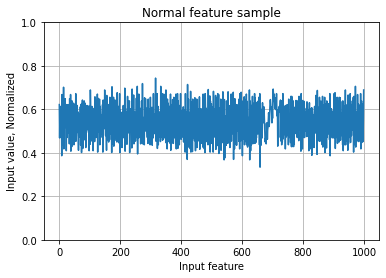

In [38]:
#Plotting sample of normal data
plt.grid()
plt.plot(np.arange(N_feature), normal_train_data[0])
plt.title("Normal feature sample")
plt.ylim([0, 1])
plt.xlabel("Input feature")
plt.ylabel("Input value, Normalized")
plt.show()

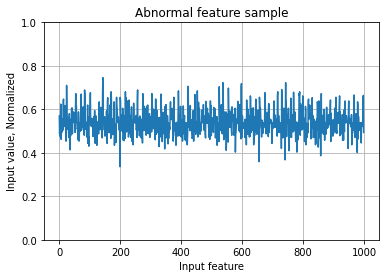

In [39]:
#Plotting sample of anomalous data
plt.grid()
plt.plot(np.arange(N_feature), anomalous_train_data[0])
plt.title("Abnormal feature sample")
plt.ylim([0, 1])
plt.xlabel("Input feature")
plt.ylabel("Input value, Normalized")
plt.show()

In [40]:
## Creating the artificial neural network using autoencoder
EMBEDDING_SIZE = 16 #Define how many neurons in the inner layer   <-----------------------------------------------------------------------------
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(EMBEDDING_SIZE, activation="relu")]) # Smallest Layer Defined Here
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(N_feature, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector() # define autoencoder model class
print("Chosen Embedding Size: ", EMBEDDING_SIZE)
# opt = keras.optimizers.Adam(learning_rate=0.0001) # default learning rate is 0.001, if you want, you can change learning rate.
# autoencoder.compile(optimizer=opt, loss='mae')
autoencoder.compile(optimizer='adam', loss='mae')

Chosen Embedding Size:  16


In [41]:
#Training the model
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=200, 
          batch_size=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0522 - val_loss: 0.0873
Epoch 2/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0500 - val_loss: 0.0819
Epoch 3/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0467 - val_loss: 0.0755
Epoch 4/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0435 - val_loss: 0.0718
Epoch 5/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0406 - val_loss: 0.0680
Epoch 6/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0386 - val_loss: 0.0659
Epoch 7/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0374 - val_loss: 0.0648
Epoch 8/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0368 - val_loss: 0.0642
Epoch 9/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0365 - val_loss: 0.0639
Epoch 10/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0362 - val_loss: 0.0642
Epoch 11/200
3/3 [==

3/3 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0647
Epoch 83/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0646
Epoch 84/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0644
Epoch 85/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0358 - val_loss: 0.0645
Epoch 86/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0358 - val_loss: 0.0648
Epoch 87/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0358 - val_loss: 0.0650
Epoch 88/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0358 - val_loss: 0.0646
Epoch 89/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0358 - val_loss: 0.0642
Epoch 90/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0358 - val_loss: 0.0644
Epoch 91/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0358 - val_loss: 0.0650
Epoch 92/200
3/3 [========

3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0647
Epoch 163/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0646
Epoch 164/200
3/3 [==============================] - ETA: 0s - loss: 0.036 - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0644
Epoch 165/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0645
Epoch 166/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0357 - val_loss: 0.0646
Epoch 167/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0646
Epoch 168/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0643
Epoch 169/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0645
Epoch 170/200
3/3 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0645
Epoch 171/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0358 - val_loss

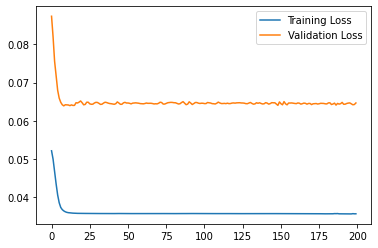

In [42]:
#Plotting the evolution of training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

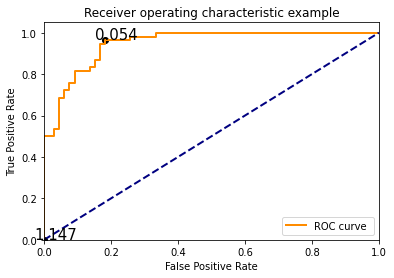

In [43]:
#Plotting True positive and false positive rate assessment
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
fpr = []
tpr = []
#the test labels are flipped to match how the roc_curve function expects them.
# flipped_labels = 1-test_labels
flipped_labels = 1-test_labels
fpr, tpr, thresholds = roc_curve(flipped_labels, loss)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

# plot some thresholds
thresholds_every=20
thresholdsLength = len(thresholds)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, thresholds_every):
  threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
  plt.scatter(fpr[i], tpr[i], c='black')
  plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15})

plt.show()

In [44]:
roc_auc = auc(fpr, tpr) # check roc auc score (the area of roc graph above)
print("ROC - AUC score is {}.".format(roc_auc))

ROC - AUC score is 0.9472502805836139.


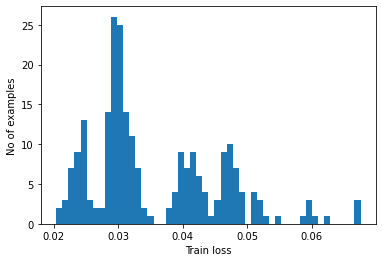

In [45]:
## reconstructions and histogram of training model
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [46]:
## Determining the threshold to detect anomalies
# threshold =  #If you want to assign a value labeled in black in the ROC graph  <-----------------------------------------------------------------------------
threshold = np.mean(train_loss) + np.std(train_loss) # Common rule of thumb
print("Threshold: ", threshold) # You have to note the threshold you will use

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

preds, scores = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Threshold:  0.045657948
Accuracy = 0.7166666666666667
Precision = 1.0
Recall = 0.48484848484848486


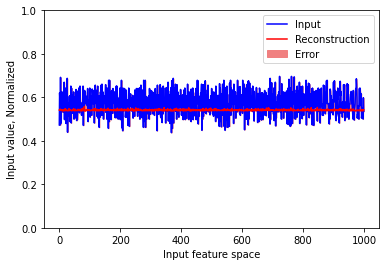

In [47]:
# Plot "Normal" test data sample with reconstruction based on created model and error
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(N_feature), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.ylim([0, 1])
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel("Input feature space")
plt.ylabel("Input value, Normalized")
plt.show()

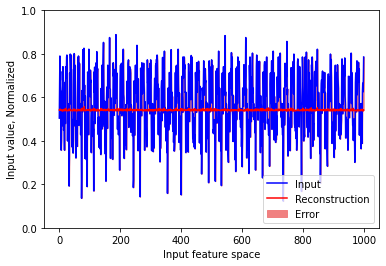

In [48]:
# Plot "Abnormal" test data sample with reconstruction based on created model and error
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(N_feature), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.ylim([0, 1])
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel("Input feature space")
plt.ylabel("Input value, Normalized")
plt.show()